In [1]:
# @title نصب و آپدیت بسته‌های مورد نیاز
import os
from textwrap import dedent

# آپدیت ابزارهای نصب
os.system("python -m pip install --upgrade pip setuptools wheel --quiet")

# نصب بسته‌های اصلی
res = os.system("python -m pip install --no-cache-dir --upgrade sentence-transformers gdown tqdm scikit-learn nltk --quiet")

# در صورت خطا، نصب مرحله‌ای
if res != 0:
    os.system("python -m pip install --no-cache-dir sentence-transformers --upgrade")
    os.system("python -m pip install --no-cache-dir gdown tqdm scikit-learn nltk --upgrade")

# نصب اختیاری rapidfuzz
os.system("python -m pip install --no-cache-dir rapidfuzz --quiet || true")

# بررسی وضعیت بسته‌ها
os.system("python -m pip show sentence-transformers || true")
os.system("python -m pip show transformers || true")
os.system("python -m pip show tokenizers || true")


0

In [2]:
# @title دانلود فایل‌ها از Google Drive با gdown
import os
from pathlib import Path

# شناسه فایل‌ها
train_id = "1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW"
test_id = "1-8TsrqTRFP-q9TM-6HinhO0ZVXFHq9TB"
map_id = "1I9aPAvvYgQWdHGKtnd7IeTGXpx8vOm4h"

data_dir = Path("/content/warranty_project")
data_dir.mkdir(parents=True, exist_ok=True)

# تابع دانلود فایل از گوگل درایو
def download_from_drive(file_id, dest):
    dest = Path(dest)
    if not dest.exists():
        url = f"https://drive.google.com/uc?id={file_id}"
        os.system(f"gdown --fuzzy {url} -O \"{dest}\"")

train_path = data_dir / "train.csv"
test_path = data_dir / "test.csv"
map_path = data_dir / "mapping.csv"

download_from_drive(train_id, train_path)
download_from_drive(test_id, test_path)
download_from_drive(map_id, map_path)


In [3]:
import pandas as pd

# نمایش ستون‌های موجود در فایل train
print(pd.read_csv(train_path, nrows=0).columns.tolist())

['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime']


In [4]:
# @title بارگذاری داده‌ها (فقط ستون‌های مورد نیاز)
import pandas as pd
import numpy as np
from tqdm import tqdm

# ستون‌های مورد نیاز
usecols = ['asin', 'reviewText', 'overall', 'summary', 'reviewerID', 'vote']

# بارگذاری داده‌ها
df = pd.read_csv(train_path, usecols=usecols, low_memory=False)
df_test = pd.read_csv(test_path, low_memory=False)
mapping = pd.read_csv(map_path, low_memory=False)

print("سایز داده‌ها:", df.shape)
display(df.head(3))
display(mapping.head(3))


سایز داده‌ها: (838944, 6)


,overall,vote,reviewerID,asin,reviewText,summary
0,2,NaN,A2OSUEZJIN7BI,0511189877,I have an older URC-WR7 remote and thought thi...,Cannot Learn
1,5,NaN,A2NETQRG6JHIG7,0511189877,First time I've EVER had a remote that needed ...,zero programming needed! Miracle!?
2,4,NaN,A12JHGROAX49G7,0511189877,Got them and only 2 of them worked. company ca...,Works Good and programs easy.


,asin,title,brand
0,0011300000,Genuine Geovision 1 Channel 3rd Party NVR IP S...,GeoVision
1,0043396828,"Books ""Handbook of Astronomical Image Processi...",33 Books Co.
2,0060009810,One Hot Summer,Visit Amazon's Carolina Garcia Aguilera Page


In [5]:
# @title پیش‌پردازش و ساخت واژگان
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from collections import Counter
from nltk.tokenize.toktok import ToktokTokenizer

# استفاده از توکنایزر سبک بدون نیاز به punkt
tokenizer = ToktokTokenizer()

# کپی داده‌های آموزشی
train_df = df.copy()

# تابع پاک‌سازی متن
def clean_text_simple(s):
    if pd.isna(s):
        return ""
    return str(s).strip().lower()

# پاک‌سازی متن‌ها
train_df['reviewText_clean'] = train_df['reviewText'].fillna('').apply(clean_text_simple)

# نمونه‌گیری برای ساخت واژگان
SAMPLE_FOR_VOCAB = 50000
sample_texts = train_df['reviewText_clean'].sample(
    min(SAMPLE_FOR_VOCAB, len(train_df)), random_state=42
).tolist()

# توکن‌سازی و شمارش واژگان
tokens = []
for txt in tqdm(sample_texts, desc="tokenizing"):
    tokens.extend(tokenizer.tokenize(txt))

token_counts = Counter({t: c for t, c in Counter(tokens).items() if t.isalpha() and len(t) > 2})

# انتخاب واژگان پرتکرار
most_common_tokens = [t for t, _ in token_counts.most_common(20000)]

print("تعداد کلمات در واژگان:", len(most_common_tokens))
print("نمونه‌ای از واژگان:", most_common_tokens[:50])

tokenizing: 100%|██████████| 50000/50000 [00:07<00:00, 6526.84it/s]


تعداد کلمات در واژگان: 20000
نمونه‌ای از واژگان: ['the', 'and', 'this', 'for', 'that', 'with', 'you', 'but', 'have', 'not', 'was', 'are', 'they', 'one', 'can', 'very', 'from', 'just', 'use', 'when', 'had', 'like', 'all', 'would', 'great', 'will', 'these', 'good', 'has', 'out', 'your', 'get', 'only', 'than', 'more', 'there', 'which', 'about', 'them', 'well', 'other', 'works', 'also', 'some', 'really', 'sound', 'don', 'work', 'what', 'quality']


In [6]:
# @title کلمات هدف اولیه و لیست اشتباهات رایج
seed_keywords = ['warranty', 'guarantee']

# مترادف‌ها و شکل‌های متداول غلط
manual_candidates = [
    'warranty', 'warranties', 'warrantee', 'warrenty', 'waranty',
    'guarantee', 'guaranteed', 'guarentee', 'guarenty', 'guaranty',
    'refund', 'replacement', 'repair', 'service', 'support', 'moneyback', 'money-back'
]

# ترکیب و یکتاسازی
seed_keywords = list(dict.fromkeys(seed_keywords + manual_candidates))
seed_keywords


['warranty',
 'guarantee',
 'warranties',
 'warrantee',
 'warrenty',
 'waranty',
 'guaranteed',
 'guarentee',
 'guarenty',
 'guaranty',
 'refund',
 'replacement',
 'repair',
 'service',
 'support',
 'moneyback',
 'money-back']

In [7]:
# @title بارگذاری مدل و یافتن کلمات مشابه معنایی
from sentence_transformers import SentenceTransformer, util
import numpy as np

# بارگذاری مدل سبک
model = SentenceTransformer("all-MiniLM-L6-v2")

# محاسبه embedding ها
candidates = most_common_tokens
cand_embs = model.encode(candidates, convert_to_tensor=True, batch_size=256, show_progress_bar=True)
seed_embs = model.encode(seed_keywords, convert_to_tensor=True, batch_size=64)

# جستجوی کلمات مشابه برای هر seed
SIM_THRESHOLD = 0.62
topn = 80
expanded_set = set()

for i, sk in enumerate(seed_keywords):
    scores = util.cos_sim(seed_embs[i], cand_embs)[0].cpu().numpy()
    idxs = np.where(scores >= SIM_THRESHOLD)[0]
    idxs_sorted = idxs[np.argsort(scores[idxs])[::-1]]
    chosen = [candidates[j] for j in idxs_sorted[:topn]]
    expanded_set.update(chosen)

# افزودن seedها به مجموعه نهایی
expanded_set.update(seed_keywords)
expanded_list = sorted(expanded_set)
expanded_list[:80]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

['assurance',
 'assure',
 'assured',
 'back',
 'backed',
 'backing',
 'broken',
 'chances',
 'damaged',
 'defect',
 'deteriorated',
 'drawback',
 'ensure',
 'fix',
 'fixable',
 'fixes',
 'fixing',
 'guarantee',
 'guaranteed',
 'guarantees',
 'guaranty',
 'guarentee',
 'guarenty',
 'gurantee',
 'maintenance',
 'money-back',
 'moneyback',
 'payback',
 'rebuilt',
 'refund',
 'refunded',
 'refunding',
 'refurb',
 'repair',
 'repairable',
 'repaired',
 'repairing',
 'repairs',
 'replace',
 'replaceable',
 'replaced',
 'replacement',
 'replacements',
 'replaces',
 'replacing',
 'salvage',
 'salvaged',
 'service',
 'serviceable',
 'serviced',
 'services',
 'servicing',
 'setback',
 'setbacks',
 'substitute',
 'support',
 'supported',
 'supporting',
 'supportive',
 'supports',
 'system',
 'talkback',
 'waranty',
 'warrant',
 'warrantech',
 'warranted',
 'warrantee',
 'warrantied',
 'warranties',
 'warrants',
 'warranty',
 'warrenty',
 'wart']

In [8]:
# @title فیلتر کردن نظرات مرتبط با warranty یا guarantee
import re

# ساخت الگوی جستجو از لیست کلمات
escaped = [re.escape(w) for w in expanded_list if w.strip()]
pattern = r'\b(' + '|'.join(escaped) + r')\b'

# فیلتر نظرات مرتبط (حساس‌نبودن به حروف بزرگ/کوچک)
mask = train_df['reviewText_clean'].str.contains(pattern, case=False, regex=True, na=False)
filtered_df = train_df[mask].copy()

print("تعداد نظرات مرتبط:", len(filtered_df))
display(filtered_df[['asin', 'overall', 'reviewText']].head(6))

/tmp/ipython-input-3352613328.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = train_df['reviewText_clean'].str.contains(pattern, case=False, regex=True, na=False)


تعداد نظرات مرتبط: 278115


,asin,overall,reviewText
1,0511189877,5,First time I've EVER had a remote that needed ...
2,0511189877,4,Got them and only 2 of them worked. company ca...
7,0594481902,2,I bought this thinking it would be a great rep...
8,0594481902,4,It works! I was skeptical about ordering it b...
10,0594296420,5,I would like to say this product works just fi...
11,0594296420,3,Purchased for my mother since she lost her ori...


In [9]:
# @title بررسی fuzzy-match برای یافتن نظرات مشابه معنایی
from rapidfuzz import fuzz
from tqdm import tqdm

# نمونه‌گیری از نظراتی که regex نگرفته
not_matched = train_df[~mask]['reviewText_clean'].sample(
    min(1000, len(train_df[~mask])), random_state=42
).tolist()

# جستجوی تقریبی
fuzzy_hits = []
FUZZY_THRESHOLD = 85
keywords = ['warranty', 'guarantee', 'warrantee', 'guaranty', 'refund', 'replacement']

for txt in tqdm(not_matched, desc="fuzzy scanning"):
    if any(fuzz.partial_ratio(kw, txt) >= FUZZY_THRESHOLD for kw in keywords):
        fuzzy_hits.append(txt)

print("تعداد fuzzy hits در نمونه:", len(fuzzy_hits))

fuzzy scanning: 100%|██████████| 1000/1000 [00:00<00:00, 18734.27it/s]

تعداد fuzzy hits در نمونه: 2


In [10]:
# @title محاسبه میانگین امتیاز overall برای هر asin در داده‌های مرتبط با warranty
result = (
    filtered_df.groupby('asin', as_index=False)['overall']
    .mean()
    .rename(columns={'overall': 'mean_overall_warranty'})
)

# افزودن تعداد نظرات مرتبط
counts = filtered_df.groupby('asin', as_index=False)['overall'] \
    .count().rename(columns={'overall': 'warranty_review_count'})
result = result.merge(counts, on='asin', how='left')

display(result.sort_values('mean_overall_warranty', ascending=False).head(10))

,asin,mean_overall_warranty,warranty_review_count
58577,B01HHO8382,5.0,1
11,1059844575,5.0,1
58629,B01HJH42KU,5.0,1
58628,B01HJH40WU,5.0,1
10,0972683275,5.0,3
9,0764207474,5.0,1
58588,B01HI0E89S,5.0,1
58589,B01HI1AGHU,5.0,1
58590,B01HI3O908,5.0,1
8,059449771X,5.0,1


In [11]:
# @title الحاق mapping و نمایش 10 محصول برتر بر اساس میانگین امتیاز warranty
mapping_cols = mapping.columns.str.lower()

# تطبیق ستون‌ها
asin_col = next((c for c in mapping.columns if c.lower() == 'asin'), 'Asin')
brand_col = next((c for c in mapping.columns if 'brand' in c.lower()), asin_col)
title_col = next((c for c in mapping.columns if 'title' in c.lower()), None)

# الحاق با داده‌های نتیجه
final = result.merge(
    mapping[[asin_col, brand_col, title_col]].rename(
        columns={asin_col:'asin', brand_col:'brand', title_col:'title'}
    ),
    on='asin', how='left'
)

# مرتب‌سازی و نمایش
final_sorted = final.sort_values(['mean_overall_warranty', 'warranty_review_count'], ascending=[False, False])
display(final_sorted[['asin', 'brand', 'title', 'warranty_review_count', 'mean_overall_warranty']].head(10))

,asin,brand,title,warranty_review_count,mean_overall_warranty
6143,B001MXQHQ0,SE,SE FC9955 Dummy Sensor Security Camera,41,5.0
5274,B0016MMYKA,beyerdynamic,beyerdynamic EDT 770 V ear pad set velour silv...,22,5.0
17834,B00C9FLSLY,Noctua,Noctua NH-U14S - Premium CPU Cooler with NF-A1...,18,5.0
5252,B0016GV1UU,MEGACRA,MEGACRA S9320 Surround Sound TV Sound Bar Speaker,17,5.0
56931,B01F3CSMH2,CableGeeker,Cat 6 Ethernet Cable 5ft (6 Pack) (at a Cat5e ...,16,5.0
31532,B00OH5JYU6,MoKo,MoKo Case Fit iPad Pro 9.7&quot; 2016 Tablet[N...,15,5.0
33114,B00QCNQXPU,iMah,iMah BT184342/BT284342 BT18433/BT28433 Phone B...,15,5.0
1857,B00017LSPI,Giotto's,Giottos AA1900 Rocket Air Blaster Large - Black,14,5.0
1858,B00017LSPI,Giotto's,Giottos AA1900 Rocket Air Blaster Large - Black,14,5.0
4920,B0011W4YNK,Tane,10 Suface Mount Magnetic Contacts,14,5.0


In [12]:
# @title ذخیره نتایج و نمایش آمار
out_dir = data_dir / "outputs"
out_dir.mkdir(exist_ok=True)

final_sorted.to_csv(out_dir / "warranty_mean_by_asin.csv", index=False)
filtered_df.to_csv(out_dir / "filtered_reviews_warranty.csv", index=False)

print("فایل‌ها ذخیره شد در:", out_dir)
print("تعداد کل نظرات مرتبط با warranty:", len(filtered_df))
print("تعداد محصولات با حداقل یک نظر مرتبط:", final_sorted['asin'].nunique())
display(filtered_df[['asin', 'overall', 'reviewText']].head(7))

فایل‌ها ذخیره شد در: /content/warranty_project/outputs
تعداد کل نظرات مرتبط با warranty: 278115
تعداد محصولات با حداقل یک نظر مرتبط: 58630


,asin,overall,reviewText
1,0511189877,5,First time I've EVER had a remote that needed ...
2,0511189877,4,Got them and only 2 of them worked. company ca...
7,0594481902,2,I bought this thinking it would be a great rep...
8,0594481902,4,It works! I was skeptical about ordering it b...
10,0594296420,5,I would like to say this product works just fi...
11,0594296420,3,Purchased for my mother since she lost her ori...
12,0594296420,5,I used this to replace the charger my Nook HD+...


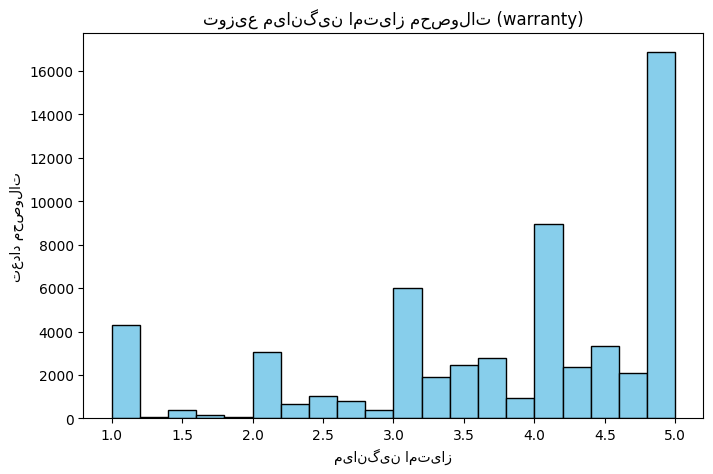

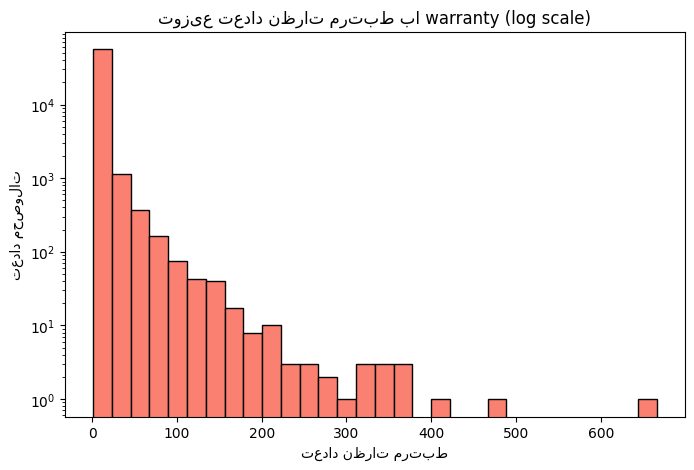

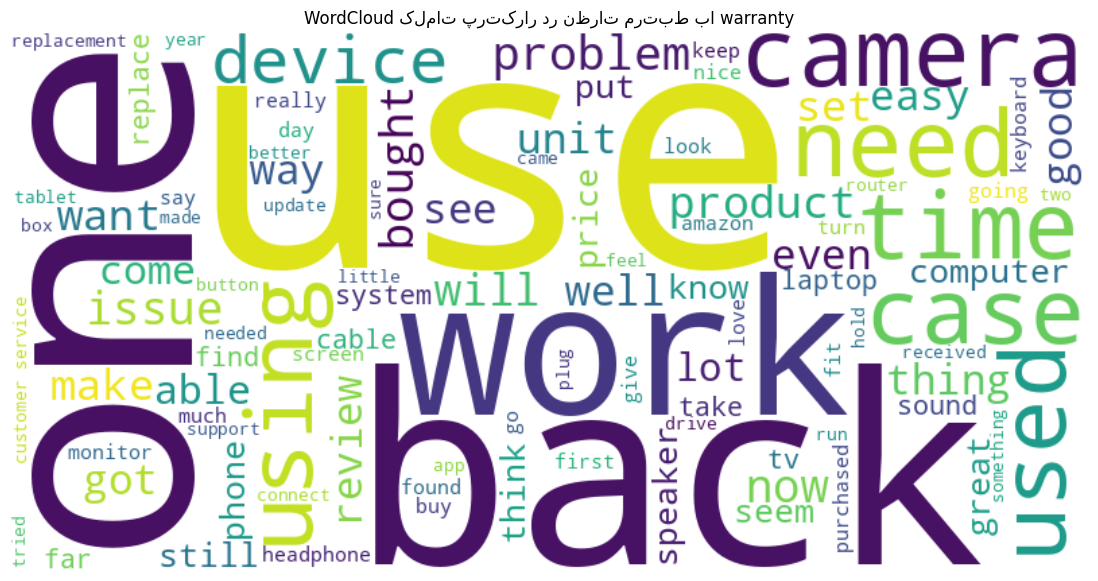

In [13]:
# @title تحلیل تکمیلی: هیستوگرام و WordCloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# هیستوگرام میانگین امتیاز محصولات مرتبط با warranty
plt.figure(figsize=(8,5))
plt.hist(result['mean_overall_warranty'], bins=20, color='skyblue', edgecolor='black')
plt.title("توزیع میانگین امتیاز محصولات (warranty)")
plt.xlabel("میانگین امتیاز")
plt.ylabel("تعداد محصولات")
plt.show()

# هیستوگرام تعداد نظرات مرتبط (log scale)
plt.figure(figsize=(8,5))
plt.hist(result['warranty_review_count'], bins=30, color='salmon', edgecolor='black', log=True)
plt.title("توزیع تعداد نظرات مرتبط با warranty (log scale)")
plt.xlabel("تعداد نظرات مرتبط")
plt.ylabel("تعداد محصولات")
plt.show()

# WordCloud از نظرات مرتبط
all_text = " ".join(filtered_df['reviewText_clean'].dropna())
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      stopwords=stopwords, max_words=100).generate(all_text)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud کلمات پرتکرار در نظرات مرتبط با warranty")
plt.show()
